![rnn diagram](http://hgrif.github.io/images/counting-architecture.png)

# Intro to RNNs
### Nikita Wootten

In [1]:
# all trivial imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as K
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from ipywidgets import interact
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Recap: Neural Networks
<img src="https://miro.medium.com/max/700/1*ZB6H4HuF58VcMOWbdpcRxQ.png" style="margin:auto;height:50%"/>

* An **artificial neural network** typically takes in a fixed size input vector and returns a fixed size output vector
* This can be used to solve all sorts of problems, from image generation to handwriting recognition to even compression

This ANN for example takes in a fixed length vector of size 4, propagates the data through two hidden layers, and finally returns a vector of size 3.

## And here lies the limitation
Many types of data can not be neatly represented as a fixed length vector. All sorts of data can be described as a *series* of data points, rather than a single fixed-length vector.

This includes problems like:
* weather/stock price forcasting
* text classification / generation
    * image captioning
* audio transcription
* machine translation

![stock market stock photo](https://sevensreport.com/wp-content/uploads/2016/07/stock-market-3.jpg)

## Introducting our benchmark dataset
We will be using [Standord's Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) as a simple benchmark dataset.

The dataset contains two columns, `review` and `sentiment`, where:
* `review` is a text column containing some user's review of a movie
* `sentiment` is a categorical column, either being `positive` or `negative`

We will be training several neural networks with the task of determining if a movie review is positive or negative

In [2]:
# download dataset from kaggle 
!kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
# unzip downloaded dataset and load into a pandas dataframe
!unzip -o imdb-dataset-of-50k-movie-reviews.zip
df = pd.read_csv("IMDB Dataset.csv")
df.head()

100%|██████████████████████████████████████| 25.7M/25.7M [00:02<00:00, 12.9MB/s]
100%|██████████████████████████████████████| 25.7M/25.7M [00:02<00:00, 11.8MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Remove extraneous datasets now that they are loaded into memory
!rm imdb-dataset-of-50k-movie-reviews.zip "IMDB Dataset.csv"
print("Remaining files:")
!ls

Remaining files:
model.png  rnn_intro.ipynb


## Basic data exploration
There are a few things to look out for when looking at any dataset.

* Did you load the expected number of records (50k)
* Is there a significant class imbalance that could be reflected in trained models
* Does the dataset contain any null values that could cause our code to crash?

The IMDB review dataset has 50000 rows


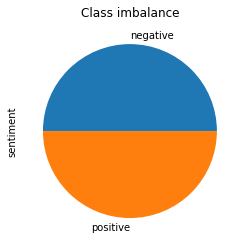

Does the dataset contain any missing values: False


In [4]:
# print number of values
print(f"The IMDB review dataset has {df.shape[0]} rows")
# plot class imbalance
df['sentiment'].value_counts().plot(kind='pie')
plt.title("Class imbalance")
plt.show()
# determine if any values are missing
print(f"Does the dataset contain any missing values: {df.isnull().values.any()}")

## Solving this problem with a conventional feed forward network
First lets try solving this problem with a regular neural network. Since a feed forward network expects a fixed-length input, we'll have to do some feature engineering to represent text data as some vector.

Our steps are as follows:
1. Clean the text data, removing html tags and punctuation, and setting everything to be lower case:

  `The movie was honestly terrible, I hated it <br> sooooooo much!!` -> `the movie was honestly terrible i hated it sooooooo much`

2. Tokenize the text:

  `the movie was honestly terrible I hated it sooooooo much` -> `['the', 'movie', 'was', 'honestly', 'terrible', 'i', 'hated', 'it', 'sooooooo', 'much']`

## Solving this problem with a conventional feed forward network (continued)
3. Create a vocabulary object that assigns a number to each word found in the dataset, then transform each token in each record into a one-hot encoding
  ![one hot encoding explanation](https://www.researchgate.net/profile/M_Reza_Faisal/publication/301703031/figure/fig2/AS:669970149158914@1536744739074/Example-of-text-representation-by-one-hot-vector.png)
4. For each record, flatten the series of vectors into a single vector representing all of the words present in the review
  *Note that this step is only needed for the feed forward network*

## Doing the transformation

In [5]:
# transform sentiment column into binary value
df['sentiment_binary'] = df['sentiment'].apply(lambda x: (1 if x == 'positive' else 0))

# first, split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'],
                                                    df['sentiment_binary'], test_size=.2, random_state=42)

MAX_WORDS = 3000 # set vector size (arbritrarily) to 3000
tokenizer = K.preprocessing.text.Tokenizer(num_words=MAX_WORDS, lower=True)
tokenizer.fit_on_texts(X_train) # feed all training reviews to build vocabulary

# convert text representation into vector of binary values (1 corresponding to the presence of a specific word)
X_train_bow = tokenizer.texts_to_matrix(X_train)
X_test_bow = tokenizer.texts_to_matrix(X_test)

* first convert the sentiment column into a binary column (0 or 1)
* split the dataset into train and test sets
* fit the tokenizer on **only the test set**
* convert the test and train reviews (X) into bag-of-words representation

## Bag-of-what?
![bow example](https://cdn-media-1.freecodecamp.org/images/1*j3HUg18QwjDJTJwW9ja5-Q.png)

In [6]:
# some randomly picked review
print("Raw text:", X_train.to_list()[5], "\n")

# bag-of-words representation
print("Bag-of-words representation:", X_train_bow[5], "\n")

print("Tokenizer index:", tokenizer.index_word)

Raw text: I don't know how this movie received so many positive reviews on this site! I'm a big vonnegut fan and am very familiar with the story this Showtime original film bastardized beyond belief, but even if I wasn't, the poor acting, VERY poor casting (Sean Astin as the brilliant, athletic, and all around individual, Harrison?? The guy's completely generic!) and sub-standard writing rendered this tripe barely watchable. Someone pointed out how cute that Maculay Culkin line was. If you read that and thought that was pure comic brilliance (sadly, it probably was the most INTENTIONALLY funny part of the movie), maybe you'll like this movie. But if you're a Vonnegut fan or not completely insane, don't see it. Please. 

Bag-of-words representation: [0. 1. 1. ... 0. 0. 0.] 

Tokenizer index: {1: 'the', 2: 'and', 3: 'a', 4: 'of', 5: 'to', 6: 'is', 7: 'br', 8: 'in', 9: 'it', 10: 'i', 11: 'this', 12: 'that', 13: 'was', 14: 'as', 15: 'for', 16: 'with', 17: 'movie', 18: 'but', 19: 'film', 20

Notice that this is a very lossy representation. A lot of information is lost turning this paragraph of text into a simple set of words.

## Feed forward network

In [7]:
bow_model = K.models.Sequential([
    K.layers.Dense(16, activation='relu', input_shape=(MAX_WORDS,)),
    K.layers.Dense(16, activation='relu'),
    K.layers.Dense(1, activation='sigmoid')
])
bow_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bow_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48016     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 48,305
Trainable params: 48,305
Non-trainable params: 0
_________________________________________________________________


## Training the network

In [8]:
bow_history = bow_model.fit(X_train_bow, y_train,
    batch_size=32, epochs=2,
    validation_data=(X_test_bow, y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 2s 57us/sample - loss: 0.3238 - accuracy: 0.8646 - val_loss: 0.2789 - val_accuracy: 0.8849
Epoch 2/2
40000/40000 [==============================] - 2s 46us/sample - loss: 0.2537 - accuracy: 0.8949 - val_loss: 0.2775 - val_accuracy: 0.8826


In [9]:
@interact(input_text='Insert your review here')
def predict_bow(input_text):
    bow = tokenizer.texts_to_matrix([input_text])
    raw = bow_model.predict(bow)[0][0]
    prediction = 'positive' if raw > .5 else 'negative'
    return f'prediction: {prediction} (raw: {raw})'

interactive(children=(Text(value='Insert your review here', description='input_text'), Output()), _dom_classes…

## What's the problem?
Information is lost in transforming sequential data into a fixed vector, including:
* The order of tokens within the text ('i hate you' vs 'you hate me') have very different meanings
* Structure and relationship of words is lost
* Repeated tokens do not effect output vector
* Stop words (such as 'I', 'the', 'it') are present in most records, they lose meaning without structure. Some of this data can be preserved with more feature engineering (e.g. by using `tf-idf` to preserve relative frequencies of words in the record).

In [10]:
predict_bow('This movie was not amazing')

'prediction: positive (raw: 0.6754549145698547)'

In [11]:
predict_bow('This movie was not terrible')

'prediction: negative (raw: 0.21061985194683075)'

More information can be preserved by using bag-of-ngrams as inputs instead of bag-of-words. However, this drastically increases the number of input dimensions that would be needed.

# Introducing: Recurrent Neural Networks!

## Preprocessing for sequential inputs
Now that we have entered the realm of RNNs, we can replace our bag-of-words representation with a representation that describes the dataset better.

In [12]:
# convert text into sequences of tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print(f'{X_train.to_list()[5]} -> {X_train_seq[5]}\n')


I don't know how this movie received so many positive reviews on this site! I'm a big vonnegut fan and am very familiar with the story this Showtime original film bastardized beyond belief, but even if I wasn't, the poor acting, VERY poor casting (Sean Astin as the brilliant, athletic, and all around individual, Harrison?? The guy's completely generic!) and sub-standard writing rendered this tripe barely watchable. Someone pointed out how cute that Maculay Culkin line was. If you read that and thought that was pure comic brilliance (sadly, it probably was the most INTENTIONALLY funny part of the movie), maybe you'll like this movie. But if you're a Vonnegut fan or not completely insane, don't see it. Please. -> [10, 89, 118, 86, 11, 17, 1972, 34, 107, 1152, 825, 20, 11, 2060, 144, 3, 193, 323, 2, 235, 51, 1083, 16, 1, 62, 11, 209, 19, 666, 2614, 18, 57, 43, 10, 291, 1, 333, 112, 51, 333, 1054, 1897, 14, 1, 511, 2, 29, 183, 2136, 1, 337, 2, 1377, 1247, 486, 11, 1179, 1722, 295, 41, 86, 

## Padding sequences
To assist with batching, pad sequences to all be the same length. This does not effect the output of the network, but it will cut off sequences of words longer then the specified length.

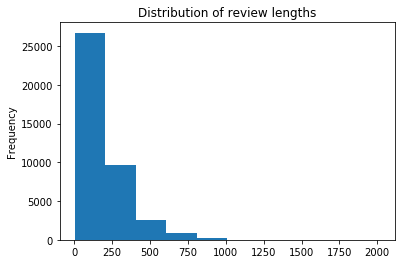

In [13]:
pd.Series(X_train_seq).apply(lambda x: len(x))\
    .plot(kind='hist')
plt.title("Distribution of review lengths")
plt.show()

# arbritrarily choose 500 words for padding
SEQ_LEN = 500

In [14]:
X_train_seq = K.preprocessing.sequence.pad_sequences(
    X_train_seq, maxlen=SEQ_LEN)
X_test_seq = K.preprocessing.sequence.pad_sequences(
    X_test_seq, maxlen=SEQ_LEN)

# notice, that the beginning has been padded with 0s
print("First 10 characters:", X_train_seq[5][:10])
print("Last 10 characters:", X_train_seq[5][-10:])

First 10 characters: [0 0 0 0 0 0 0 0 0 0]
Last 10 characters: [   3  323   38   21  337 2061   89   64    9  590]


Note that padding sequences is not required unless you are batching your inputs. You can still use longer sequences during inference.

## Simple RNNs

![rnn diagram](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/1920px-Recurrent_neural_network_unfold.svg.png)
* Recurrent neural networks contain loops!
    * when you unroll the network, it's really just a vanilla neural network with the same cell copied over and over

* Data is fed in one step at a time
    * the output of the previous step is concatenated with the next input
    * Once all data has been fed, the final result gets sent to the next hidden layer
    * (and the neural network carries on as if it were a normal feed forward network)
    * Backpropogation works the same, except that working backwards you are updating the same weights several times *(note this causes problems)*

* The idea of unrolling has been around since at least 1969, the term 'Recurrent Neural Network' was probably introduced in 1985

## Building and training an RNN

In [15]:
rnn_model = K.models.Sequential([
    # convert index representation into one hot vector
    K.layers.Embedding(MAX_WORDS, 16),
    # RNN of 16 dense layers
    K.layers.SimpleRNN(16),
    # use output state in classification
    K.layers.Dense(16, activation='relu'),
    K.layers.Dense(1, activation='sigmoid')
])
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          48000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 48,817
Trainable params: 48,817
Non-trainable params: 0
_________________________________________________________________


In [16]:
rnn_history = rnn_model.fit(X_train_seq, y_train,
    batch_size=32, epochs=2,
    validation_data=(X_test_seq, y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 72s 2ms/sample - loss: 0.5582 - accuracy: 0.6989 - val_loss: 0.4044 - val_accuracy: 0.8289
Epoch 2/2
40000/40000 [==============================] - 74s 2ms/sample - loss: 0.3755 - accuracy: 0.8424 - val_loss: 0.3754 - val_accuracy: 0.8439


In [17]:
@interact(input_text='Insert your review here')
def predict_rnn(input_text):
    seq = tokenizer.texts_to_sequences([input_text])
    raw = rnn_model.predict(seq)[0][0]
    prediction = 'positive' if raw > .5 else 'negative'
    return f'prediction: {prediction} (raw: {raw})'

interactive(children=(Text(value='Insert your review here', description='input_text'), Output()), _dom_classes…

* Notice how much slower this trains, taking roughly 2ms per sample on my machine, compared to 52us/s for the feed forward network
    * despite having roughly the same number of parameters (~48,000)
* Try the inputs `This movie was not amazing` and `This movie was not terrible`
    * Same problem, has it learned these relations?

## Vanishing gradient problem
Vanilla RNNs in particular tend to suffer from the vanishing gradient problem, this is because:
* When RNNs are unrolled, they are very deep
* The same weights are being updated over and over again
* Information is lost between time steps, making it difficult to represent long range dependencies

In the end, this means that RNNs tend to forget old information very quickly!

## LSTM (Long Short-Term Memory) networks

![lstm diagram](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1920px-Long_Short-Term_Memory.svg.png)

* First described in 1997, and refined through 2000
* Designed explicitly to overcome vanishing gradient problem, and allow for long range dependencies
* Used extensively today by Facebook, Google, Amazon, and Apple
* Can still suffer from **exploding gradients**

## But how does it work?
The core idea behind an LSTM is the interaction between the `cell state`, `forget gate`, `input gate`, and `output gate`.
![lstm detailed diagram](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

* The `cell state` is the line of data running on top of the diagram
    * Long range dependencies are stored here.
    * This is what allows the network to overcome the **vanishing gradient problem**
        * because it is allowed to *flow* from one cell to another
* The `forget gate` is represented by the left-most `sigmoid` layer leading into  the `cell state`
    * Since the `sigmoid` activation function bounds the input between `0` and `1`
        * this functionally lets the LSTM choose how much to forget
* The `input gate` is made up of a `sigmoid` and `tanh` layer
    * It controlls what information is *added* to the `cell state`
    * The `tanh` and `sigmoid` layers are multiplied together, and their output is added to the `cell state`
* The `output gate` is the part on the right, made of a `sigmoid` layer and a `tanh` activation function
    * `sigmoid` layer of cell input multiplied by the `cell state`
    * Output is sent to next cell, as well as to the `output state`.
    * The next cell concatenates its input with the previous `output state`

# Building and training an LSTM

In [18]:
lstm_model = K.models.Sequential([
    # convert index representation into one hot vector
    K.layers.Embedding(MAX_WORDS, 16),
    # RNN of 16 dense layers
    K.layers.LSTM(16),
    # use output state in classification
    K.layers.Dense(16, activation='relu'),
    K.layers.Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          48000     
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 50,401
Trainable params: 50,401
Non-trainable params: 0
_________________________________________________________________


In [19]:
lstm_history = lstm_model.fit(X_train_seq, y_train,
    batch_size=32, epochs=2,
    validation_data=(X_test_seq, y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 108s 3ms/sample - loss: 0.3670 - accuracy: 0.8340 - val_loss: 0.2755 - val_accuracy: 0.8870
Epoch 2/2
40000/40000 [==============================] - 103s 3ms/sample - loss: 0.2665 - accuracy: 0.8921 - val_loss: 0.2622 - val_accuracy: 0.8928


In [20]:
@interact(input_text='Insert your review here')
def predict_lstm(input_text):
    seq = tokenizer.texts_to_sequences([input_text])
    raw = lstm_model.predict(seq)[0][0]
    prediction = 'positive' if raw > .5 else 'negative'
    return f'prediction: {prediction} (raw: {raw})'

interactive(children=(Text(value='Insert your review here', description='input_text'), Output()), _dom_classes…

* Notice that there are a few more parameters (50,000 vs 48,000) due to the added gates
* Training is even slower this time! Up to 3ms/sample on my machine

## LSTM Variants
Several variants of the vanilla LSTM exist.

*diagrams are via Chris Olah's blog. please check his website out, a lot of great resources*

### Peephole LSTM
![peephole lstm](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-peepholes.png)


### LSTM with coupled forget/input gates
![coupled lstm](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-tied.png)

* these variants have been shown to have similar performance
    * there are **MANY** more variants
* here is a very popular (and widely used) variant:

## GRU (Gated Recurrent Unit) networks
![gru diagram](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Gated_Recurrent_Unit.svg/1920px-Gated_Recurrent_Unit.svg.png)

* Described in 2014 by Kyunghyun Cho et al.
* Simpler than an LSTM with fewer parameters
    * Merges `forget` and `input` gates
    * Merges `cell state` with `output state`
* Shown to have similar performance in music, speech, and natural language processing tasks
* Shown to have ever better performance on smaller datasets

* LSTMs have been shown to be stronger then a GRU in tasks such as unbounded counting and LSTMs consistently outperform GRUs in machine translation

## Building and training a GRU

In [21]:
gru_model = K.models.Sequential([
    # convert index representation into one hot vector
    K.layers.Embedding(MAX_WORDS, 16),
    # RNN of 16 dense layers
    K.layers.GRU(16),
    # use output state in classification
    K.layers.Dense(16, activation='relu'),
    K.layers.Dense(1, activation='sigmoid')
])
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          48000     
_________________________________________________________________
gru (GRU)                    (None, 16)                1632      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 49,921
Trainable params: 49,921
Non-trainable params: 0
_________________________________________________________________


In [22]:
gru_history = gru_model.fit(X_train_seq, y_train,
    batch_size=32, epochs=2,
    validation_data=(X_test_seq, y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 111s 3ms/sample - loss: 0.4016 - accuracy: 0.8068 - val_loss: 0.2756 - val_accuracy: 0.8876
Epoch 2/2
40000/40000 [==============================] - 110s 3ms/sample - loss: 0.2648 - accuracy: 0.8939 - val_loss: 0.2543 - val_accuracy: 0.8964


In [23]:
@interact(input_text='Insert your review here')
def predict_gru(input_text):
    seq = tokenizer.texts_to_sequences([input_text])
    raw = gru_model.predict(seq)[0][0]
    prediction = 'positive' if raw > .5 else 'negative'
    return f'prediction: {prediction} (raw: {raw})'

interactive(children=(Text(value='Insert your review here', description='input_text'), Output()), _dom_classes…

## Breakdown / Results
Some analysis:
* Accuracy increases a bit with the LSTM and GRU networks.
    * LSTM seems to begin overfitting even on two epochs
* None of the networks learned negation (e.g. the phrase `not great` or `not terrible` would not result in the output becoming more positive
    * *Note that this is really subjective to me, another reviewer may still consider `not terrible` to be a negative review*
* The domain of long-form text reviews may not apply well to our short snippets of text

## Simple models are explainable (at least, easier to explain)

In [24]:
lr_model = LogisticRegression().fit(X_train_bow, y_train)
print("LR model accuracy:", lr_model.score(X_test_bow, y_test))

LR model accuracy: 0.8835


In [25]:
weight_comparison = pd.concat([
    pd.DataFrame({'type': "ZERO MASK"}, index=[0]), # tokenizer reserves 0-index for masking
    pd.DataFrame.from_dict(tokenizer.index_word, orient='index', columns=['type']).iloc[:2999] # tokenizer words by index
])
weight_comparison['lr_weight'] = lr_model.coef_[0] # attach weights from logistic regression model

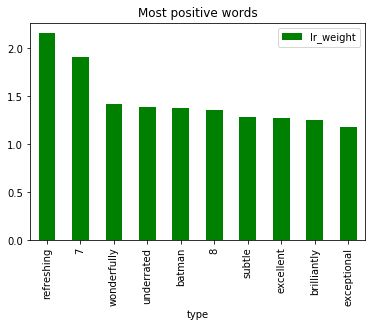

In [26]:
weight_comparison.reindex(weight_comparison.lr_weight.sort_values(ascending=False).index).head(10)\
    .plot.bar(x='type', y='lr_weight', color='green')
plt.title("Most positive words")
plt.show()

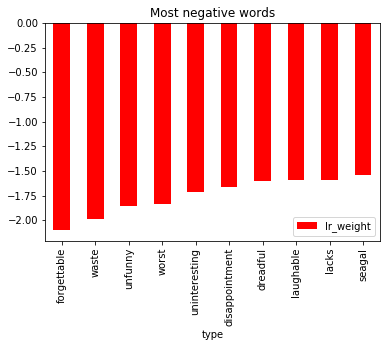

In [27]:
weight_comparison.reindex(weight_comparison.lr_weight.sort_values(ascending=True).index).head(10)\
    .plot.bar(x='type', y='lr_weight', color='red')
plt.title("Most negative words")
plt.show()

## Simple models are explainable (continued)

In [28]:
# for those who are interested, what's the deal with "tony" being so positive
@interact(word='tony')
def plot_weight_of_word(word):
    # get popularity in dataset
    contains_word_selection = df[df.review.str.lower().str.contains(word)]
    if contains_word_selection.empty:
        return f'{word} is not found in the IMDB Reviews Dataset'
    contains_word_selection.sentiment.value_counts().plot.pie()
    plt.title(f'Popularity of "*{word}*" in the IMDB Movie Dataset')
    # get weight of LR model
    return f'LogisticRegression weights: {list(weight_comparison[weight_comparison.type.str.match(word)].lr_weight)}'

interactive(children=(Text(value='tony', description='word'), Output()), _dom_classes=('widget-interact',))

## What other tasks can RNNs accomplish?
In general, RNNs are used to tackle three types of tasks:
<table>
<thead>
  <tr>
    <th>Type</th>
    <th>Use Cases</th>
    <th>Diagram / Example</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>sequence to vector</td>
    <td>text classification, stock price prediction</td>
    <td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/1920px-Recurrent_neural_network_unfold.svg.png" width="400"></td>
  </tr>
  <tr>
    <td>sequence to sequence</td>
    <td>document summarization, translation, audio transcription, natural entity recognition</td>
    <td><img src="https://miro.medium.com/max/700/1*Ismhi-muID5ooWf3ZIQFFg.png" width="400" height="185"></td>
  </tr>
  <tr>
    <td>vector to sequence</td>
    <td>image captioning, text generation, music generation</td>
    <td><img src="https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png" width="400" height="189"></td>
  </tr>
</tbody>
</table>

# The problem with RNNs
* RNNs are much slower then feed forward networks
    * LSTM cells cannot be parallelized, data is fed one step at a time
* Internal state is lossy, *vanishing gradient* means older items of the sequence get lost
    * Can be addressed with Bidirectional RNNs & attention
    * Forward-directional LSTMs tend to forget the beginning of a sequence, Bi-LSTMs tend to forget the middle of a sequence
* In general RNNs (especially LSTMs) are very prone to overfitting. Regularization is a must.
    * Recurrent dropout is expensive

# New advances
![pyramid of advances](https://iq.opengenus.org/content/images/2020/05/Screenshot-from-2020-05-24-23-48-04.png)
The state of NLP and Machine Learning is constantly evolving!

## Bidirectional LSTMs
![blstm](http://colah.github.io/posts/2015-09-NN-Types-FP/img/RNN-bidirectional.png)
* One LSTM is fed in forwards, the other is fed in backwards, the results are concatenated
* Can drastically increase performance in text classification/translation/generation tasks
    * Can't really be used in next-token-prediction tasks (language models need to be trained differently)
* Very simple to use with Keras!
    ```python
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(X))
    ```

## Attention
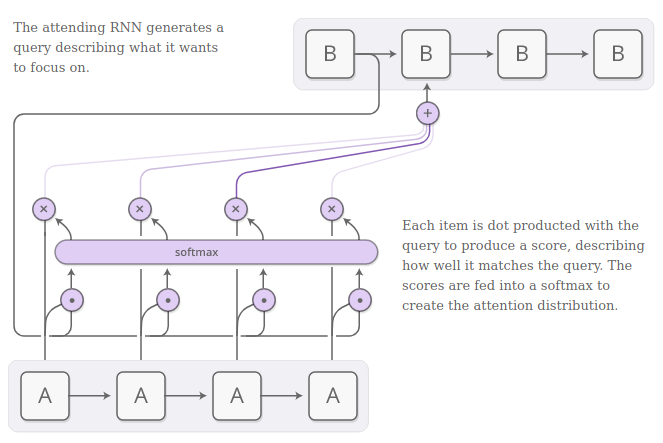
*Note: diagram from [Chris Olah on attention mechanisms](https://distill.pub/2016/augmented-rnns/#attentional-interfaces)*

* A family of techniques used in NLP, audio and vision processing
* Can be applied to sequence-to-sequence models (like machine translation)
    * For each output token, a context vector is generated telling the network how much it should *pay attention* to the input tokens
* Also has easy to use Keras implementations
    ```python
    tf.keras.layers.AttentionLayer()
    ```
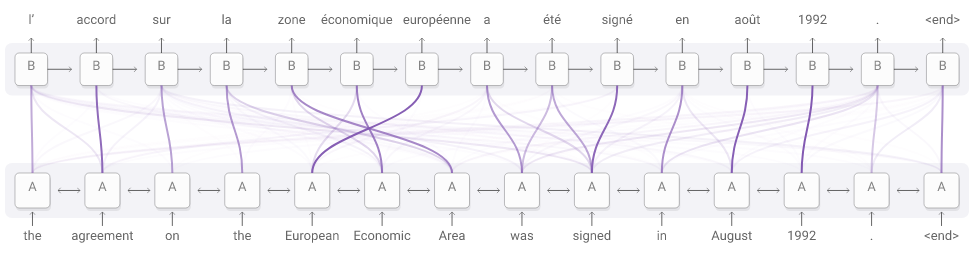

## Intro the transformer

![bert and elmo (and ernie I guess)](https://media4.s-nbcnews.com/i/newscms/2018_38/2570706/180918-bert-ernie-smithsonian-ew-1240p_2e84c24596832edf3688fcb3e216b1c7.jpg)
*see: [BERT (Bidirectional Encoder Representations from Transformers)](https://arxiv.org/abs/1810.04805v2)*

* Proposed in 2017 with the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762)
    * Has Keras implementation (through seperate package)
* Designed specifically for language modeling
* NOT a recurrent neural network. Just a very complicated feed-forward network
    * Made up of an encoder and decoder network utilizing attention
* Scales much better, and can be parallelized easier.
    * Has been scaled to **ridiculous sizes**
![gpt scaling](https://lh4.googleusercontent.com/-RfT5AozxlC0Lmxc_7I39xvs9j0fqdylBrZDR3oocriuT8ulqT7YKBAZuORP9RZZtGrp6nFi7pGrrG1FdZ3yyzvKs1mnkqiwvLxoDCro2qkEAzMAcjl52x803mpNaG49LXiUmT97)

## References and interesting reads
* On the Practical Computational Power of Finite Precision RNNsfor Language Recognition (https://arxiv.org/pdf/1805.04908.pdf): Interesting paper showing how an LSTM is stronger than a GRU
* Neural Networks and Deep Learning Ch. 5 http://neuralnetworksanddeeplearning.com/chap5.html - A great explanation of vanishing gradients
* Colah's blog on LSTMs https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - A great read on LSTMs
* Colah's blog on Attention https://distill.pub/2016/augmented-rnns/ - Also a great read
* https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html - In depth article on attention mechanisms
* http://jalammar.github.io/illustrated-transformer/ - More details on transformers
* https://openai.com/blog/better-language-models/ - Paper (and blog post) on OpenAI's very large language model, GPT